Import requirements, and suppress warnings from Sklearn

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score, recall_score, f1_score, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipe_imb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

Read data and inspect final 5 rows of DataFrame

In [ ]:
df = pd.read_csv('drive/MyDrive/BankChurners.csv')
df.tail()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000
10126,714337233,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,6,2,4,10388.0,1961,8427.0,0.703,10294,61,0.649,0.189


Inspecting the target label counts we can see this will be an imblanced classification problem.

In [ ]:
df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

Encode the target label (*Attrition_Flag*) in a seperate array and drop this and *CLIENTNUM* from the feature DataFrame.

In [ ]:
le = LabelEncoder()
le.classes_ = np.array(['Existing Customer', 'Attrited Customer']) # Override label order so Churn = 1
y = le.transform(df['Attrition_Flag'])
df = df.drop(['Attrition_Flag', 'CLIENTNUM'], axis=1)

Group features into the following:


*   Categorical features: Most of these will be one-hot encoded, however if there are only two distinct variables we will binary encode instead
*   Numerical features: continuous variables that will be scaled during preprocessing
*   Binary Categorical Features: Categorical features with only two distinct values. Will be binary encoded.



In [ ]:
CATEGORICAL_FEATURES = ['Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
NUMERICAL_FEATURES = [col for col in df.columns if col not in CATEGORICAL_FEATURES]

Preprocessing DataFrame using ColumnTransformer.

In [ ]:
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('num', StandardScaler(), NUMERICAL_FEATURES),
    ('cat', OneHotEncoder(sparse=False), CATEGORICAL_FEATURES)
])

df_new = pd.DataFrame(preprocessing_pipeline.fit_transform(df))

This code section retrieves feature (column) names for our preprocessed DataFrame. This will be useful for plotting feature importance.

In [ ]:
l_transformers = list(preprocessing_pipeline._iter(fitted=True))
column_names = []
for name, trans, column, _ in l_transformers:
  if hasattr(trans, 'get_feature_names'):
    column_names.extend(trans.get_feature_names(column))
  else:
    column_names.extend(column)

Standard Train-Test split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.2, random_state=11)

### Model Training and Tuning

We are using a combination of minority over-sampling (BorderlineSMOTE) and majority random under-sampling to tackle the target class imbalance.

Model architecture: LightGBM

First step is a 5-fold randomized hyper-parmater search for the LGBM paramaters. We fix learning rate (0.03) and n_estimators (100).

F1 Scoring is used based on target class balance and business problem.

In [ ]:
sm = BorderlineSMOTE(sampling_strategy=0.3)
rus = RandomUnderSampler(sampling_strategy=0.6)

lgb = LGBMClassifier(objective = 'binary')
train_pipeline = pipe_imb([('sm', sm), ('rus', rus), ('clf', lgb)])
param_dist = {'clf__n_estimators': [100],
              'clf__learning_rate': [0.03],
              'clf__subsample': [i/10.0 for i in range(6,10)],
              'clf__max_depth': [3, 4, 5, 6],
              'clf__colsample_bytree': [i/10.0 for i in range(6,10)],
              'clf__min_child_weight': range(1,6,2)
             }

clf = RandomizedSearchCV(train_pipeline, 
                         param_distributions = param_dist,
                         cv = 5,  
                         n_iter = 20,  
                         scoring = 'f1', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train.values, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score=0,
                   estimator=Pipeline(memory=None,
                                      steps=[('sm',
                                              BorderlineSMOTE(k_neighbors=5,
                                                              kind='borderline-1',
                                                              m_neighbors=10,
                                                              n_jobs=1,
                                                              random_state=None,
                                                              sampling_strategy=0.3)),
                                             ('rus',
                                              RandomUnderSampler(random_state=None,
                                                                 ratio=None,
                                                                 replacement=False,
                                                                 return_indices=F

In [ ]:
clf.best_score_, clf.best_params_

(0.8752511926962345,
 {'clf__colsample_bytree': 0.6,
  'clf__learning_rate': 0.03,
  'clf__max_depth': 6,
  'clf__min_child_weight': 1,
  'clf__n_estimators': 100,
  'clf__subsample': 0.8})

Custom evaluation metric for use in the next section.

In [ ]:
def lgb_f1_score(y_hat, data):
    y_true = np.where(data > 0.5, 1, 0)
    return 'f1', f1_score(y_true, y_hat), True

Using the best parameters from the random search, we increase n_estimators and use the LGBM early stopping implementation to optimise this parameter.

5-fold stratified CV is used with our custom f1 eval metric defined above.

In [ ]:
lgbm =  clf.best_estimator_.steps[-1][-1]
params = {'learning_rate':0.03, 'n_estimators':5000}
lgbm.set_params(**params)
train_pipeline_es = pipe_imb([('sm', sm), ('rus', rus), ('clf', lgbm)])

kf= StratifiedKFold(shuffle = True)

stopping_rounds = []

for train_index, test_index in kf.split(X_train, y_train):
  X_train2, X_val = X_train.values[train_index], X_train.values[test_index]
  y_train2, y_val = y_train[train_index], y_train[test_index]

  fit_params={"clf__early_stopping_rounds":50, 
            "clf__eval_metric" : lgb_f1_score, 
            "clf__eval_set" : [[X_val, y_val]],
            "clf__verbose": 25}


  train_pipeline_es.fit(X_train2, y_train2, **fit_params)

  stopping_rounds.append(train_pipeline_es.steps[-1][-1].booster_.best_iteration)


Training until validation scores don't improve for 50 rounds.
[25]	valid_0's binary_logloss: 0.325122	valid_0's f1: 0.870588
[50]	valid_0's binary_logloss: 0.233864	valid_0's f1: 0.855019
[75]	valid_0's binary_logloss: 0.183158	valid_0's f1: 0.865672
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.325122	valid_0's f1: 0.870588
Training until validation scores don't improve for 50 rounds.
[25]	valid_0's binary_logloss: 0.323874	valid_0's f1: 0.862669
[50]	valid_0's binary_logloss: 0.22842	valid_0's f1: 0.865672
[75]	valid_0's binary_logloss: 0.175363	valid_0's f1: 0.877778
[100]	valid_0's binary_logloss: 0.144081	valid_0's f1: 0.895028
[125]	valid_0's binary_logloss: 0.127169	valid_0's f1: 0.895028
[150]	valid_0's binary_logloss: 0.115366	valid_0's f1: 0.896679
[175]	valid_0's binary_logloss: 0.106593	valid_0's f1: 0.89464
[200]	valid_0's binary_logloss: 0.100679	valid_0's f1: 0.896679
[225]	valid_0's binary_logloss: 0.0957439	valid_0's f1: 0.902985
[250]	valid_0's b

Re-fit on all training data using best parameters.

In [ ]:
best_estimators = int(np.ceil(np.mean(stopping_rounds)))

lgbm_final =  lgbm
params_final = {'learning_rate':0.03, 'n_estimators':best_estimators}
lgbm_final.set_params(**params_final)
train_pipeline_final = pipe_imb([('sm', sm), ('rus', rus), ('clf', lgbm_final)])

train_pipeline_final.fit(X_train.values, y_train)

Pipeline(memory=None,
         steps=[('sm',
                 BorderlineSMOTE(k_neighbors=5, kind='borderline-1',
                                 m_neighbors=10, n_jobs=1, random_state=None,
                                 sampling_strategy=0.3)),
                ('rus',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.6)),
                ('clf',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=0.6, importance_type='split',
                                learning_rate=0.03, max_depth=6,
                                min_child_samples=20, min_child_weight=1,
                                min_split_gain=0.0, n_estimators=184, n_jobs=-1,
                                num_leaves=31, objective='binary',
                                random_state=None, reg_alp

Predict on test set. Note that imblearn's pipeline implementation will only use sampling methods on fit and not predict.

Print precision, recall, f1 and accuracy.

In [ ]:
preds = train_pipeline_final.predict(X_test.values)

print('Precision: {}'.format(precision_score(y_test, preds)))
print('Recall: {}'.format(recall_score(y_test, preds)))
print('F1: {}'.format(f1_score(y_test, preds)))
print('Accuracy: {}'.format(accuracy_score(y_test, preds)))

Precision: 0.8838526912181303
Recall: 0.9541284403669725
F1: 0.9176470588235294
Accuracy: 0.9723593287265548


Confusion Matrix using predictions.



*   False Negative: These are want we want to avoid as it results in a missed customer that churns.
*   False Positive: Incorrectly predicting a churn. The implications of this depend on the business strategy (e.g. what is the cost of attempting to prevent a churn?).



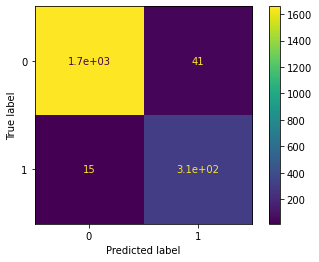

In [ ]:
plot_confusion_matrix(train_pipeline_final, X_test.values, y_test)

Plot feature importances using column names extracted earlier.

In [ ]:
feat_imp = train_pipeline_final.steps[-1][-1].booster_.feature_importance()
feat_imp_mapped = dict(zip(column_names, feat_imp))

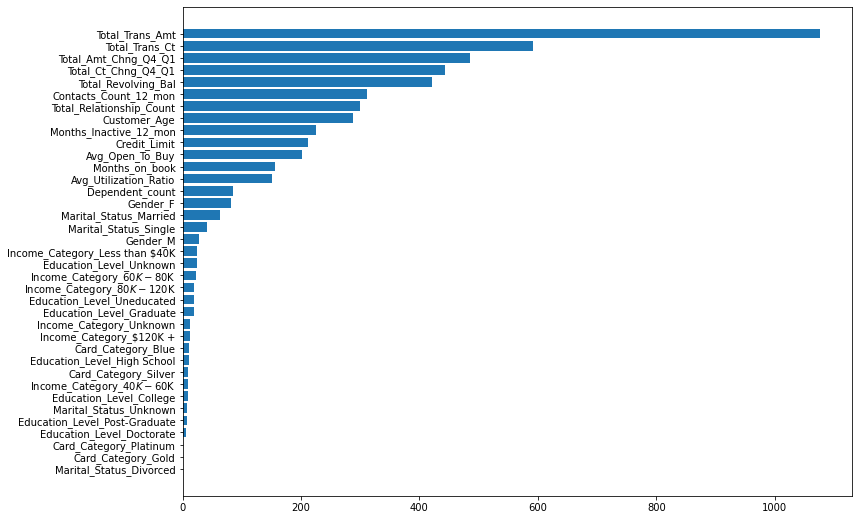

In [ ]:
feat_imp_mapped = sorted(feat_imp_mapped.items(), key=lambda x:x[1])
plt.figure(figsize=(12,9))
plt.barh(range(len(feat_imp_mapped)), [x[1] for x in feat_imp_mapped], align='center')
plt.yticks(range(len(feat_imp_mapped)), [x[0] for x in feat_imp_mapped])
plt.yticks(rotation=0)
plt.show()

Save trained model and preprocessing pipeline for online inference.

In [ ]:
final_model = train_pipeline_final.steps[-1][-1]

final_pipeline = Pipeline([('preprocess', preprocessing_pipeline), ('model', final_model)])

joblib.dump(final_pipeline, 'drive/MyDrive/churn_pipeline.pkl')


['drive/MyDrive/churn_pipeline.pkl']